# Chapter 10

Examples and Exercises from Think Stats, 2nd Edition

http://thinkstats2.com

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT


In [94]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")

In [95]:
import numpy as np

import random

import thinkstats2
import thinkplot

## Least squares

One more time, let's load up the NSFG data.

In [96]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/first.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dct")
download(
    "https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dat.gz"
)

In [97]:
import first
live, firsts, others = first.MakeFrames()
live = live.dropna(subset=['agepreg', 'totalwgt_lb'])
ages = live.agepreg
weights = live.totalwgt_lb

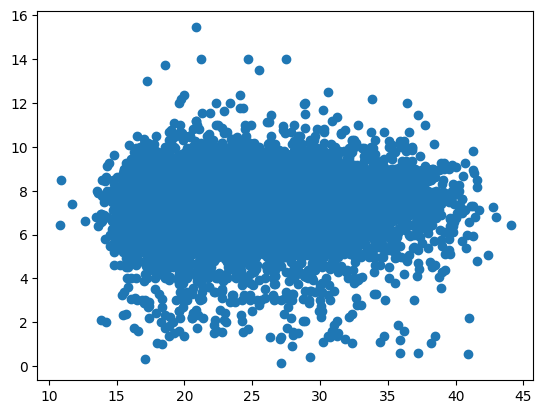

In [98]:
import matplotlib.pyplot as plt

plt.scatter(ages, weights)

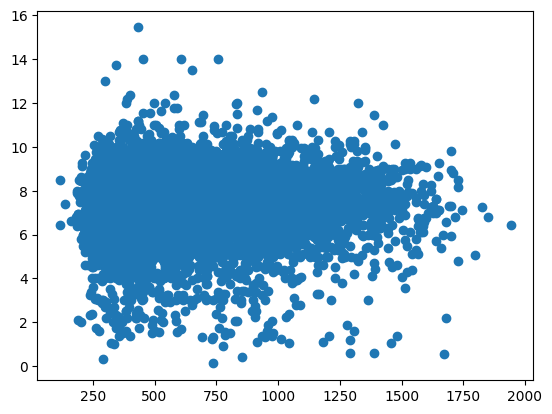

In [101]:
plt.scatter(ages**2, weights)

In [6]:
cov=np.dot((ages-ages.mean()),(weights-weights.mean()))/len(weights)
slope=cov/np.var(ages)
interc=weights.mean()-slope*weights.mean()

0.017453851471802753 7.138815257674707


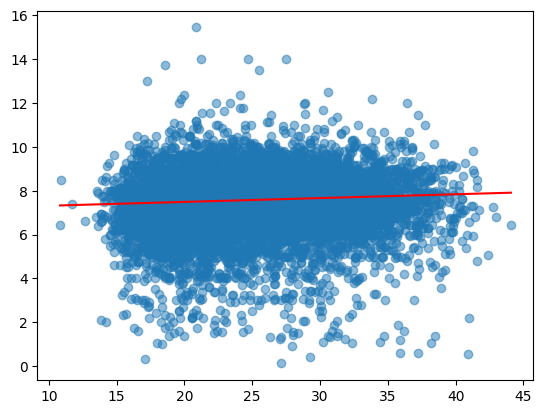

In [7]:
x=np.sort(ages)
y=interc+slope*x
print(slope,interc)
plt.plot(x,y, color="red")
plt.scatter(ages, weights, alpha=0.5)

In [8]:
import pandas as pd
residuals = [(weights-(interc+slope*ages))]
myframe= pd.DataFrame(weights, columns=["weight"])
myframe["age"]=ages
myframe["residu"]=np.vstack(residuals)[0]
myframe["weight"]=weights

In [9]:
print(myframe["weight"])

0        8.8125
1        7.8750
2        9.1250
3        7.0000
4        6.1875
          ...  
13581    6.3750
13584    6.3750
13588    6.1875
13591    7.5000
13592    7.5000
Name: weight, Length: 9038, dtype: float64


In [10]:
myframe2=myframe.sort_values("age")

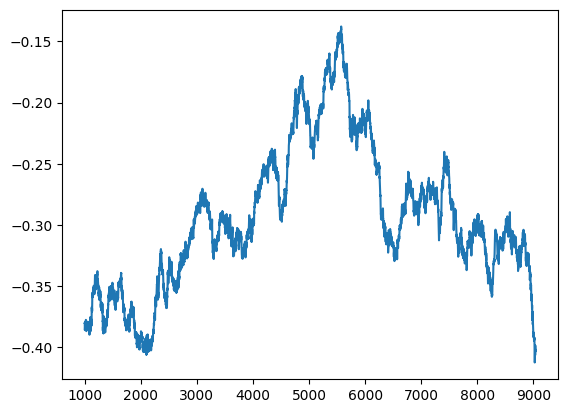

In [11]:
plt.plot(np.arange(9038), myframe2["residu"].rolling(window=1000).mean())

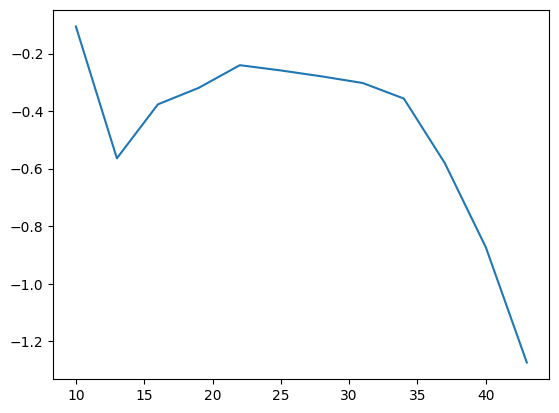

In [12]:
groupcont=np.arange(10,45,3)
indices = np.digitize(myframe["age"], groupcont)
groups=myframe.groupby(indices)

resmean=[group[1]["residu"].mean() for group in groups]

plt.plot(groupcont,resmean)

In [13]:
cdfs=[]
for group in groups:
    cdfs.append(thinkstats2.Cdf(group[1]["residu"]))



c:\python\thinkstats\solutions\thinkstats2.py:162: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self.d.update(obj.value_counts().iteritems())
c:\python\thinkstats\solutions\thinkstats2.py:162: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self.d.update(obj.value_counts().iteritems())
c:\python\thinkstats\solutions\thinkstats2.py:162: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self.d.update(obj.value_counts().iteritems())
c:\python\thinkstats\solutions\thinkstats2.py:162: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self.d.update(obj.value_counts().iteritems())
c:\python\thinkstats\solutions\thinkstats2.py:162: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self.d.update(obj.value_counts().iteritems())
c:\py

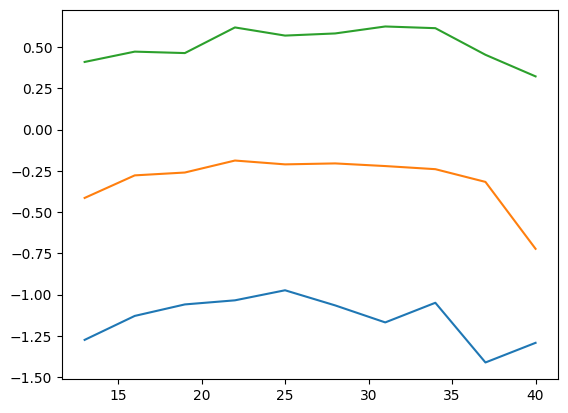

In [14]:

for percent in [25,50,75]:
    resy=[]
    for cdf in cdfs[1:-1]:   
        resy.append(cdf.Percentile(percent))  
    plt.plot(groupcont[1:-1],resy) 



The following function computes the intercept and slope of the least squares fit.

In [15]:
from thinkstats2 import Mean, MeanVar, Var, Std, Cov

def LeastSquares(xs, ys):
    meanx, varx = MeanVar(xs)
    meany = Mean(ys)

    slope = Cov(xs, ys, meanx, meany) / varx
    inter = meany - slope * meanx

    return inter, slope

Here's the least squares fit to birth weight as a function of mother's age.

In [16]:
inter, slope = LeastSquares(ages, weights)
inter, slope

(6.830396973311053, 0.017453851471802746)

The intercept is often easier to interpret if we evaluate it at the mean of the independent variable.

In [17]:
inter + slope * 25

7.266743260106122

And the slope is easier to interpret if we express it in pounds per decade (or ounces per year).

In [18]:
slope * 10

0.17453851471802745

The following function evaluates the fitted line at the given `xs`.

In [19]:
def FitLine(xs, inter, slope):
    fit_xs = np.sort(xs)
    fit_ys = inter + slope * fit_xs
    return fit_xs, fit_ys

And here's an example.

In [20]:
fit_xs, fit_ys = FitLine(ages, inter, slope)

Here's a scatterplot of the data with the fitted line.

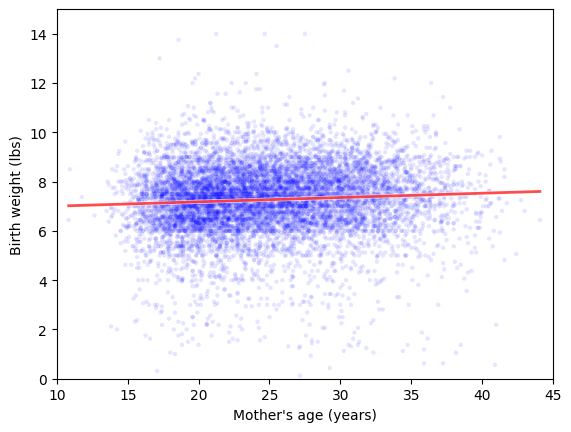

In [21]:
thinkplot.Scatter(ages, weights, color='blue', alpha=0.1, s=10)
thinkplot.Plot(fit_xs, fit_ys, color='white', linewidth=3)
thinkplot.Plot(fit_xs, fit_ys, color='red', linewidth=2)
thinkplot.Config(xlabel="Mother's age (years)",
                 ylabel='Birth weight (lbs)',
                 axis=[10, 45, 0, 15],
                 legend=False)

## Residuals

The following functon computes the residuals.

In [22]:
def Residuals(xs, ys, inter, slope):
    xs = np.asarray(xs)
    ys = np.asarray(ys)
    res = ys - (inter + slope * xs)
    return res

Now we can add the residuals as a column in the DataFrame.

In [23]:
live['residual'] = Residuals(ages, weights, inter, slope)

To visualize the residuals, I'll split the respondents into groups by age, then plot the percentiles of the residuals versus the average age in each group.

First I'll make the groups and compute the average age in each group.

In [24]:
bins = np.arange(10, 48, 3)
indices = np.digitize(live.agepreg, bins)
groups = live.groupby(indices)


age_means = [group.agepreg.mean() for _, group in groups][1:-1]
age_means

[15.212333333333335,
 17.740359281437126,
 20.506304824561404,
 23.455752212389378,
 26.435156146179406,
 29.411177432542924,
 32.30232530120482,
 35.240273631840786,
 38.10876470588235,
 40.91205882352941]

Next I'll compute the CDF of the residuals in each group.

In [25]:
cdfs = [thinkstats2.Cdf(group.residual) for _, group in groups][1:-1]

c:\python\thinkstats\solutions\thinkstats2.py:162: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self.d.update(obj.value_counts().iteritems())
c:\python\thinkstats\solutions\thinkstats2.py:162: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self.d.update(obj.value_counts().iteritems())
c:\python\thinkstats\solutions\thinkstats2.py:162: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self.d.update(obj.value_counts().iteritems())
c:\python\thinkstats\solutions\thinkstats2.py:162: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self.d.update(obj.value_counts().iteritems())
c:\python\thinkstats\solutions\thinkstats2.py:162: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self.d.update(obj.value_counts().iteritems())
c:\py

The following function plots percentiles of the residuals against the average age in each group.

In [26]:
def PlotPercentiles(age_means, cdfs):
    thinkplot.PrePlot(3)
    for percent in [75, 50, 25]:
        weight_percentiles = [cdf.Percentile(percent) for cdf in cdfs]
        label = '%dth' % percent
        thinkplot.Plot(age_means, weight_percentiles, label=label)

The following figure shows the 25th, 50th, and 75th percentiles.

Curvature in the residuals suggests a non-linear relationship.

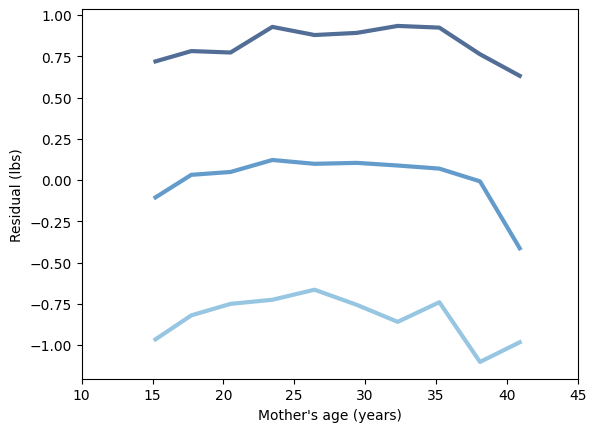

In [27]:
PlotPercentiles(age_means, cdfs)

thinkplot.Config(xlabel="Mother's age (years)",
                 ylabel='Residual (lbs)',
                 xlim=[10, 45])

## Sampling distribution

To estimate the sampling distribution of `inter` and `slope`, I'll use resampling.

In [28]:
def SampleRows(df, nrows, replace=False):
    """Choose a sample of rows from a DataFrame.

    df: DataFrame
    nrows: number of rows
    replace: whether to sample with replacement

    returns: DataDf
    """
    indices = np.random.choice(df.index, nrows, replace=replace)
    sample = df.loc[indices]
    return sample

def ResampleRows(df):
    """Resamples rows from a DataFrame.

    df: DataFrame

    returns: DataFrame
    """
    return SampleRows(df, len(df), replace=True)

The following function resamples the given dataframe and returns lists of estimates for `inter` and `slope`.

In [29]:
def SamplingDistributions(live, iters=101):
    t = []
    for _ in range(iters):
        sample = ResampleRows(live)
        ages = sample.agepreg
        weights = sample.totalwgt_lb
        estimates = LeastSquares(ages, weights)
        t.append(estimates)

    inters, slopes = zip(*t)
    return inters, slopes

Here's an example.

In [30]:
inters, slopes = SamplingDistributions(live, iters=1001)

The following function takes a list of estimates and prints the mean, standard error, and 90% confidence interval.

In [31]:
def Summarize(estimates, actual=None):
    mean = Mean(estimates)
    stderr = Std(estimates, mu=actual)
    cdf = thinkstats2.Cdf(estimates)
    ci = cdf.ConfidenceInterval(90)
    print('mean, SE, CI', mean, stderr, ci)

Here's  the summary for `inter`.

In [32]:
Summarize(inters)

mean, SE, CI 6.830559710678321 0.0714026454115824 (6.7049999249069, 6.9463840922716775)


And for `slope`.

In [33]:
Summarize(slopes)

mean, SE, CI 0.01745746055617097 0.0028268188346898242 (0.012864915996327391, 0.02213502163576566)


**Exercise:** Use `ResampleRows` and generate a list of estimates for the mean birth weight.  Use `Summarize` to compute the SE and CI for these estimates.

In [34]:
# Solution

iters = 1000
estimates = [ResampleRows(live).totalwgt_lb.mean()
             for _ in range(iters)]
Summarize(estimates)

mean, SE, CI 7.264795619882717 0.01470977515565177 (7.239889909271962, 7.288635483514052)


## Visualizing uncertainty

To show the uncertainty of the estimated slope and intercept, we can generate a fitted line for each resampled estimate and plot them on top of each other.

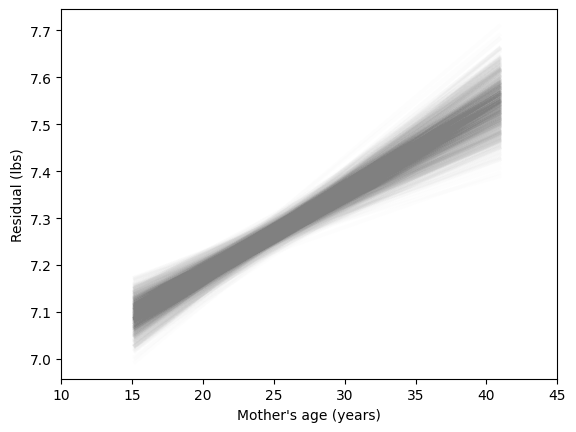

In [35]:
for slope, inter in zip(slopes, inters):
    fxs, fys = FitLine(age_means, inter, slope)
    thinkplot.Plot(fxs, fys, color='gray', alpha=0.01)
    
thinkplot.Config(xlabel="Mother's age (years)",
                 ylabel='Residual (lbs)',
                 xlim=[10, 45])

Or we can make a neater (and more efficient plot) by computing fitted lines and finding percentiles of the fits for each value of the dependent variable.

In [36]:
def PlotConfidenceIntervals(xs, inters, slopes, percent=90, **options):
    fys_seq = []
    for inter, slope in zip(inters, slopes):
        fxs, fys = FitLine(xs, inter, slope)
        fys_seq.append(fys)

    p = (100 - percent) / 2
    percents = p, 100 - p
    low, high = thinkstats2.PercentileRows(fys_seq, percents)
    thinkplot.FillBetween(fxs, low, high, **options)

This example shows the confidence interval for the fitted values at each mother's age.

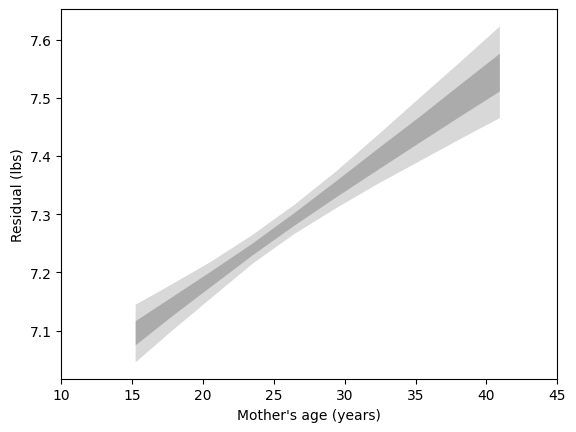

In [37]:
PlotConfidenceIntervals(age_means, inters, slopes, percent=90, 
                        color='gray', alpha=0.3, label='90% CI')
PlotConfidenceIntervals(age_means, inters, slopes, percent=50,
                        color='gray', alpha=0.5, label='50% CI')

thinkplot.Config(xlabel="Mother's age (years)",
                 ylabel='Residual (lbs)',
                 xlim=[10, 45])

In [38]:
print(age_means)

[15.212333333333335, 17.740359281437126, 20.506304824561404, 23.455752212389378, 26.435156146179406, 29.411177432542924, 32.30232530120482, 35.240273631840786, 38.10876470588235, 40.91205882352941]


## Coefficient of determination



The coefficient compares the variance of the residuals to the variance of the dependent variable.

In [39]:
def CoefDetermination(ys, res):
    return 1 - Var(res) / Var(ys)

For birth weight and mother's age $R^2$ is very small, indicating that the mother's age predicts a small part of the variance in birth weight.

In [40]:
inter, slope = LeastSquares(ages, weights)
res = Residuals(ages, weights, inter, slope)
r2 = CoefDetermination(weights, res)
r2

0.004738115474710258

We can confirm that $R^2 = \rho^2$:

In [41]:
print('rho', thinkstats2.Corr(ages, weights))
print('R', np.sqrt(r2))    

rho 0.06883397035410904
R 0.06883397035410828


To express predictive power, I think it's useful to compare the standard deviation of the residuals to the standard deviation of the dependent variable, as a measure RMSE if you try to guess birth weight with and without taking into account mother's age.

In [42]:
print('Std(ys)', Std(weights))
print('Std(res)', Std(res))

Std(ys) 1.40821553384062
Std(res) 1.4048754287857834


As another example of the same idea, here's how much we can improve guesses about IQ if we know someone's SAT scores.

In [43]:
var_ys = 15**2
rho = 0.72
r2 = rho**2
var_res = (1 - r2) * var_ys
std_res = np.sqrt(var_res)
std_res

10.409610943738484

## Hypothesis testing with slopes

Here's a `HypothesisTest` that uses permutation to test whether the observed slope is statistically significant.

In [44]:
class SlopeTest(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        ages, weights = data
        _, slope = thinkstats2.LeastSquares(ages, weights)
        return slope

    def MakeModel(self):
        _, weights = self.data
        self.ybar = weights.mean()
        self.res = weights - self.ybar

    def RunModel(self):
        ages, _ = self.data
        weights = self.ybar + np.random.permutation(self.res)
        return ages, weights

And it is.

In [45]:
ht = SlopeTest((ages, weights))
pvalue = ht.PValue()
pvalue

0.0

Under the null hypothesis, the largest slope we observe after 1000 tries is substantially less than the observed value.

In [46]:
ht.actual, ht.MaxTestStat()

(0.017453851471802746, 0.007100044348350431)

We can also use resampling to estimate the sampling distribution of the slope.

In [47]:
sampling_cdf = thinkstats2.Cdf(slopes)

The distribution of slopes under the null hypothesis, and the sampling distribution of the slope under resampling, have the same shape, but one has mean at 0 and the other has mean at the observed slope.

To compute a p-value, we can count how often the estimated slope under the null hypothesis exceeds the observed slope, or how often the estimated slope under resampling falls below 0.

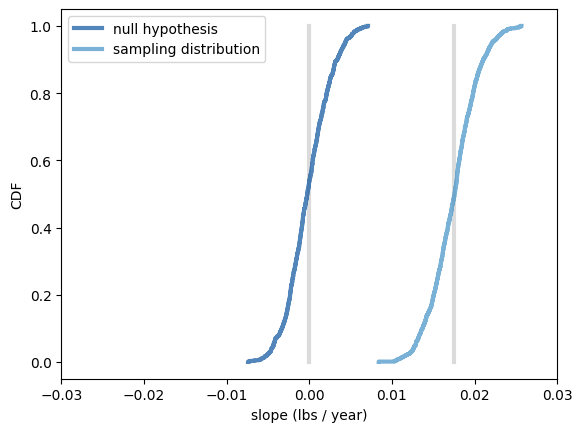

In [48]:
thinkplot.PrePlot(2)
thinkplot.Plot([0, 0], [0, 1], color='0.8')
ht.PlotCdf(label='null hypothesis')

thinkplot.Cdf(sampling_cdf, label='sampling distribution')

thinkplot.Config(xlabel='slope (lbs / year)',
                   ylabel='CDF',
                   xlim=[-0.03, 0.03],
                   legend=True, loc='upper left')

Here's how to get a p-value from the sampling distribution.

In [49]:
pvalue = sampling_cdf[0]
pvalue

0

## Resampling with weights

Resampling provides a convenient way to take into account the sampling weights associated with respondents in a stratified survey design.

The following function resamples rows with probabilities proportional to weights.

In [50]:
def ResampleRowsWeighted(df, column='finalwgt'):
    weights = df[column]
    cdf = thinkstats2.Cdf(dict(weights))
    indices = cdf.Sample(len(weights))
    sample = df.loc[indices]
    return sample

We can use it to estimate the mean birthweight and compute SE and CI.

In [51]:
iters = 100
estimates = [ResampleRowsWeighted(live).totalwgt_lb.mean()
             for _ in range(iters)]
Summarize(estimates)

mean, SE, CI 7.347203543372427 0.014081686135746917 (7.325355443682231, 7.368727871210445)


And here's what the same calculation looks like if we ignore the weights.

In [52]:
estimates = [thinkstats2.ResampleRows(live).totalwgt_lb.mean()
             for _ in range(iters)]
Summarize(estimates)

mean, SE, CI 7.26583584587298 0.016112670693005524 (7.240145773401195, 7.291698937818102)


The difference is non-negligible, which suggests that there are differences in birth weight between the strata in the survey.

# Exercises

**Exercise:** Using the data from the BRFSS, compute the linear least squares fit for log(weight) versus height. How would you best present the estimated parameters for a model like this where one of the variables is log-transformed? If you were trying to guess someone’s weight, how much would it help to know their height?

Like the NSFG, the BRFSS oversamples some groups and provides a sampling weight for each respondent. In the BRFSS data, the variable name for these weights is totalwt. Use resampling, with and without weights, to estimate the mean height of respondents in the BRFSS, the standard error of the mean, and a 90% confidence interval. How much does correct weighting affect the estimates?

Read the BRFSS data and extract heights and log weights.

In [53]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/brfss.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/CDBRFS08.ASC.gz")

In [54]:
import brfss

df = brfss.ReadBrfss(nrows=None)
df = df.dropna(subset=['htm3', 'wtkg2'])
heights, weights = df.htm3, df.wtkg2
log_weights = np.log10(weights)

In [55]:
slope=np.cov(heights,weights, dtype="float64")[0][1]/np.var(heights)
incerp=weights.mean()-slope*heights.mean()
xs=np.arange(heights.min(),heights.max())
xs2=sorted(heights.unique())
print(slope)
ys=incerp+np.multiply(slope,xs2)


0.9570770029201157


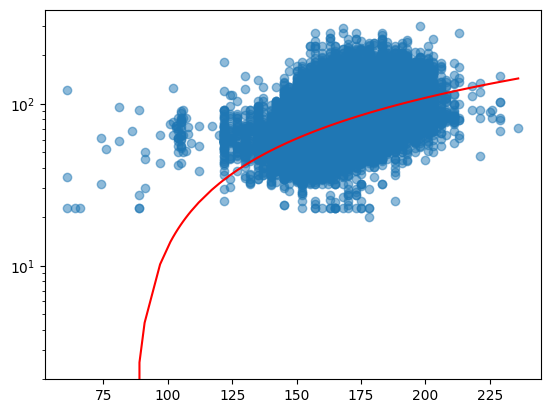

In [56]:
plt.scatter(heights,weights, alpha=0.5)
plt.plot(xs2, ys ,color="red")
plt.yscale("log")

In [57]:
slope2=np.cov(heights,log_weights, dtype="float64")[0][1]/np.var(heights)
incerp2=log_weights.mean()-slope2*heights.mean()
xs=np.arange(heights.min(),heights.max())
xs2=sorted(heights.unique())
print(slope2)
ys2=incerp2+np.multiply(slope2,xs2)


0.005281467512117483


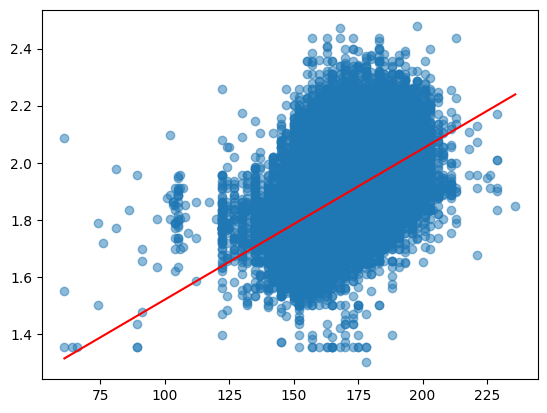

In [58]:
plt.scatter(heights,log_weights, alpha=0.5)
plt.plot(xs2, ys2 ,color="red")
#plt.yscale("log")

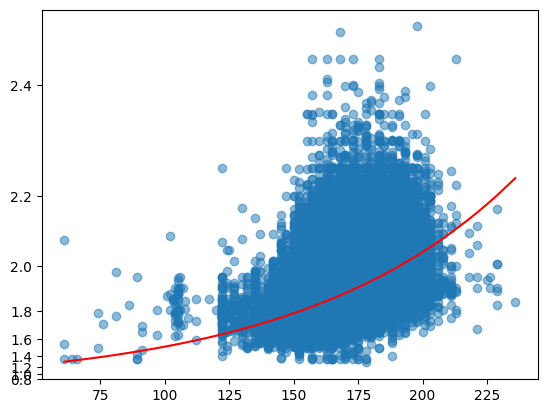

In [59]:
from functools import partial
plt.scatter(heights, log_weights, alpha=0.5)
plt.plot(  xs2, ys2 ,color="red")
plt.yscale('function', functions=(partial(np.power, 10.0), np.log10))

In [60]:
residuals=thinkstats2.Residuals(heights,log_weights,incerp2,slope2)


In [61]:
cccdf=thinkstats2.Cdf(residuals)
print(cccdf)

Cdf([-0.63214938 -0.58805405 -0.57657994 ...  0.61346435  0.62222445
  0.77047091], [2.52632430e-06 5.05264860e-06 1.01052972e-05 ... 9.99994947e-01
 9.99997474e-01 1.00000000e+00])


c:\python\thinkstats\solutions\thinkstats2.py:162: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self.d.update(obj.value_counts().iteritems())
c:\python\thinkstats\solutions\thinkstats2.py:162: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self.d.update(obj.value_counts().iteritems())
c:\python\thinkstats\solutions\thinkstats2.py:162: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self.d.update(obj.value_counts().iteritems())
c:\python\thinkstats\solutions\thinkstats2.py:162: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self.d.update(obj.value_counts().iteritems())
c:\python\thinkstats\solutions\thinkstats2.py:162: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self.d.update(obj.value_counts().iteritems())
c:\py

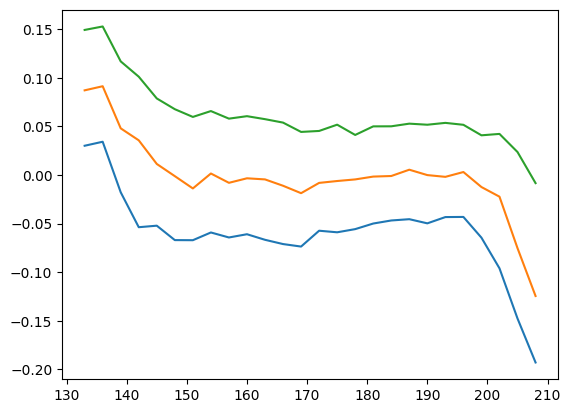

In [62]:
import pandas as pd
bins=np.arange(130,210,3)
mydata={"height":heights, "log_weights": log_weights, "weights":weights}
mydataframe=pd.DataFrame(mydata)

mydataframe["simulate"]=mydataframe["height"].apply(lambda x:np.multiply(slope2,x)+incerp2)
indicies=np.digitize(mydataframe["height"],bins)
groups=mydataframe.groupby(indicies)
ys_groups=incerp2+np.multiply(slope2,bins)

residual_groups=[]
for group in groups:
  residual_groups.append(group[1]["log_weights"]-group[1]["simulate"].mean())

for percen in [25,50,75]:
  cccf=[]
  for residual in residual_groups[1:-1]:
    cccf.append(thinkstats2.Cdf(residual).Percentile(percen))
  plt.plot(bins[1:],cccf)


               height  log_weights   weights  simulate
height       1.000000     0.531728  0.508736  1.000000
log_weights  0.531728     1.000000  0.984058  0.531728
weights      0.508736     0.984058  1.000000  0.508736
simulate     1.000000     0.531728  0.508736  1.000000


<AxesSubplot: >

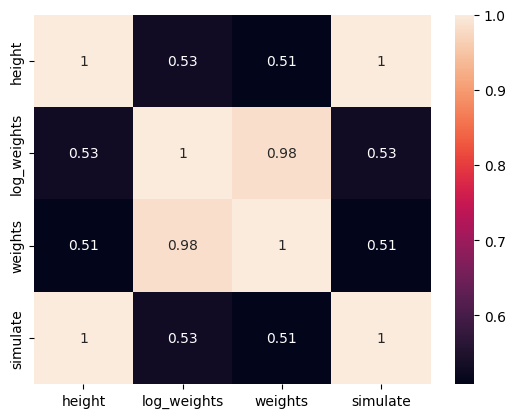

In [63]:
import seaborn as sns
from seaborn.rcmod import palettes
print(mydataframe.corr())
sns.heatmap(mydataframe.corr(), color=sns.color_palette("tab10"), annot=True)

In [64]:
covariance= np.dot((mydataframe["height"]-mydataframe["height"].mean()) , (mydataframe["log_weights"]-mydataframe["log_weights"].mean()))/len(mydataframe["height"])
covariance2= ((mydataframe["height"]-mydataframe["height"].mean()) * (mydataframe["weights"]-mydataframe["weights"].mean())).sum()/len(mydataframe["height"])
print(covariance, covariance2)
corellation= covariance / (mydataframe["height"].std()*mydataframe["log_weights"].std())
corellation2= covariance2 / (mydataframe["height"].std()*mydataframe["weights"].std())
print(corellation, corellation2)

0.5702251730182563 103.33290857697766
0.531726917280321 0.5087351937401301


In [65]:
SSres=((mydataframe["log_weights"]-mydataframe["simulate"])**2).sum()
print(SSres)
SStot=((mydataframe["log_weights"]-mydataframe["log_weights"].mean())**2).sum()
print(SStot)
Rhigh2=1-SSres/SStot
print(Rhigh2)

3024.2033453101967
4216.298168006354
0.2827349431171351


In [66]:
p=np.cov(mydataframe["height"], mydataframe['log_weights'])[0][1]/(mydataframe["height"].std()*mydata["log_weights"].std() )
print(p)
print(p**2)

0.5317282605983426
0.2827349431189389


In [67]:
def SamplingDistributions(heightweight, iters=101):
    t = []
    for _ in range(iters):
        sample = thinkstats2.ResampleRows(heightweight)
        height = sample.height
        weight = sample.log_weights
        estimates = thinkstats2.LeastSquares(height, weight)
        t.append(estimates)
    inters, slopes = zip(*t)
    return inters, slopes

In [68]:
mydata={"height":heights, "log_weights": log_weights, "weights":weights}
mydataframe=pd.DataFrame(mydata)

In [69]:
inters,slopes= SamplingDistributions(mydataframe[["height","log_weights"]])


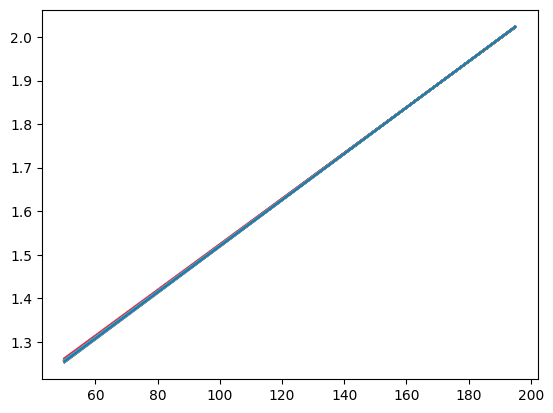

In [70]:
xxxs= np.arange(50,200,5)
for i in range(len(slopes)):
    #print(inters[i])
    ys=inters[i]+np.multiply(slopes[i],xxxs)
    plt.plot(xxxs,ys)


Estimate intercept and slope.

In [71]:
# Solution

inter, slope = thinkstats2.LeastSquares(heights, log_weights,)
inter, slope

(0.9930804163932496, 0.005281454169418002)

Make a scatter plot of the data and show the fitted line.

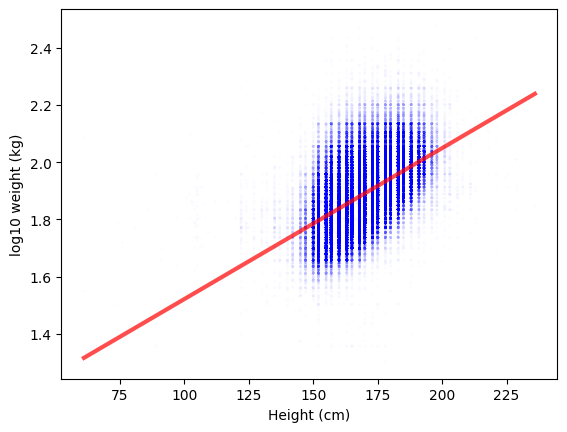

In [72]:
# Solution

thinkplot.Scatter(heights, log_weights, alpha=0.01, s=5)
fxs, fys = thinkstats2.FitLine(heights, inter, slope)
thinkplot.Plot(fxs, fys, color='red')
thinkplot.Config(xlabel='Height (cm)', ylabel='log10 weight (kg)', legend=False)

Make the same plot but apply the inverse transform to show weights on a linear (not log) scale.

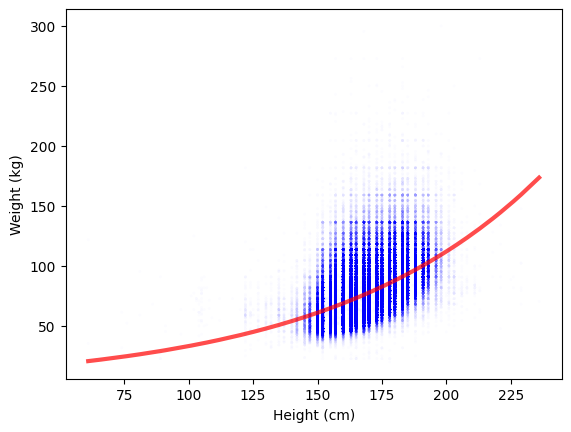

In [73]:
# Solution

thinkplot.Scatter(heights, weights, alpha=0.01, s=5)
fxs, fys = thinkstats2.FitLine(heights, inter, slope)
thinkplot.Plot(fxs, 10**fys, color='red')
thinkplot.Config(xlabel='Height (cm)', ylabel='Weight (kg)', legend=False)

Plot percentiles of the residuals.

c:\python\thinkstats\solutions\thinkstats2.py:162: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self.d.update(obj.value_counts().iteritems())
c:\python\thinkstats\solutions\thinkstats2.py:162: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self.d.update(obj.value_counts().iteritems())
c:\python\thinkstats\solutions\thinkstats2.py:162: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self.d.update(obj.value_counts().iteritems())
c:\python\thinkstats\solutions\thinkstats2.py:162: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self.d.update(obj.value_counts().iteritems())
c:\python\thinkstats\solutions\thinkstats2.py:162: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self.d.update(obj.value_counts().iteritems())
c:\py

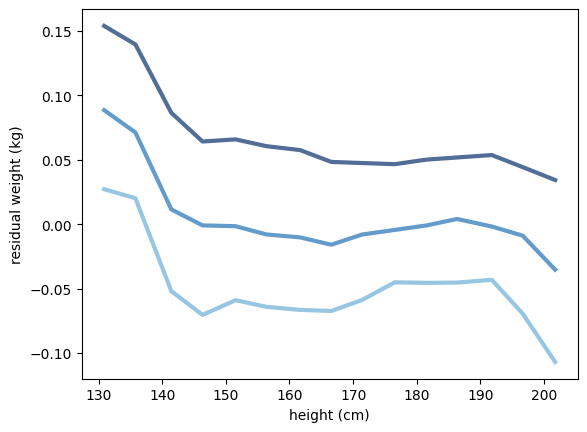

In [74]:
# Solution

# The lines are flat over most of the range, 
# indicating that the relationship is linear.

# The lines are mostly parallel, indicating 
# that the variance of the residuals is the 
# same over the range.

res = thinkstats2.Residuals(heights, log_weights, inter, slope)
df['residual'] = res

bins = np.arange(130, 210, 5)
indices = np.digitize(df.htm3, bins)
groups = df.groupby(indices)

means = [group.htm3.mean() for i, group in groups][1:-1]
cdfs = [thinkstats2.Cdf(group.residual) for i, group in groups][1:-1]

thinkplot.PrePlot(3)
for percent in [75, 50, 25]:
    ys = [cdf.Percentile(percent) for cdf in cdfs]
    label = '%dth' % percent
    thinkplot.Plot(means, ys, label=label)
    
thinkplot.Config(xlabel='height (cm)', ylabel='residual weight (kg)', legend=False)

Compute correlation.

In [75]:
# Solution

rho = thinkstats2.Corr(heights, log_weights)
rho

0.5317282605983575

Compute coefficient of determination.

In [76]:
# Solution

r2 = thinkstats2.CoefDetermination(log_weights, res)
r2

0.28273494311893366

Confirm that $R^2 = \rho^2$.

In [77]:
# Solution

np.isclose(rho**2, r2)

True

Compute Std(ys), which is the RMSE of predictions that don't use height.

In [78]:
# Solution

std_ys = thinkstats2.Std(log_weights)
std_ys

0.10320725030004863

Compute Std(res), the RMSE of predictions that do use height.

In [79]:
# Solution

std_res = thinkstats2.Std(res)
std_res

0.087407770804161

How much does height information reduce RMSE?

In [80]:
# Solution

1 - std_res / std_ys

0.15308497658793052

Use resampling to compute sampling distributions for inter and slope.

In [81]:
# Solution

t = []
for _ in range(100):
    sample = thinkstats2.ResampleRows(df)
    estimates = thinkstats2.LeastSquares(sample.htm3, np.log10(sample.wtkg2))
    t.append(estimates)

inters, slopes = zip(*t)

Plot the sampling distribution of slope.

{'xscale': 'linear', 'yscale': 'linear'}

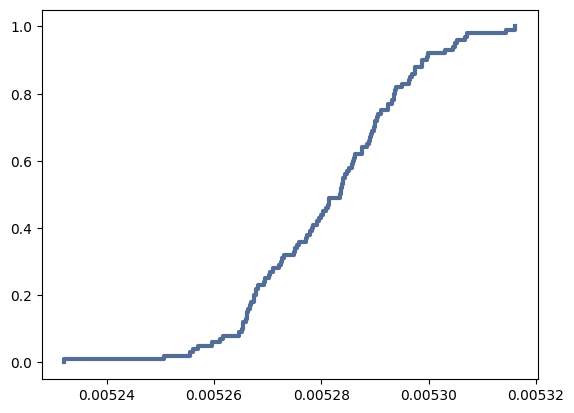

In [82]:
# Solution

cdf = thinkstats2.Cdf(slopes)
thinkplot.Cdf(cdf)

Compute the p-value of the slope.

In [83]:
# Solution
#werte von meiner slope die kleiner 0 sind. Wenn slope kleiner 0 vorkommt dann wuerde dies bedeuten dass die richtung der slope sich aendert z.b. von herabschauend
#auf heraufschauend. dies waer ein zeichen dass die slope nicht genau ist z.b.
pvalue = cdf[0]
pvalue


0

Compute the 90% confidence interval of slope.

In [84]:
# Solution

ci = cdf.Percentile(5), cdf.Percentile(95)
ci

(0.0052569616378177675, 0.005304980192316561)

Compute the mean of the sampling distribution.

In [85]:
# Solution

mean = thinkstats2.Mean(slopes)
mean

0.00528162045166583

Compute the standard deviation of the sampling distribution, which is the standard error.

In [86]:
# Solution

stderr = thinkstats2.Std(slopes)
stderr

1.4646600589709576e-05

Resample rows without weights, compute mean height, and summarize results.

In [87]:
# Solution

estimates_unweighted = [thinkstats2.ResampleRows(df).htm3.mean() for _ in range(100)]
Summarize(estimates_unweighted)

mean, SE, CI 168.9550831413327 0.01499887988724195 (168.9300713433982, 168.97649507872026)


Resample rows with weights.  Note that the weight column in this dataset is called `finalwt`.

In [88]:
# Solution

# The estimated mean height is almost 2 cm taller 
# if we take into account the sampling weights,
# and this difference is much bigger than the sampling error.

estimates_weighted = [ResampleRowsWeighted(df, 'finalwt').htm3.mean() for _ in range(100)]
Summarize(estimates_weighted)

mean, SE, CI 170.49591435255354 0.017737950562828186 (170.46773883869923, 170.52567503385274)


In [89]:
slope3=np.cov(mydataframe["height"],mydataframe["log_weights"], dtype="float64")[0][1]/np.var(mydataframe["height"])
incerp4=mydataframe["log_weights"].mean()-slope2*mydataframe["height"].mean()
print(slope3)
print(incerp4)

0.005281467512117483
0.9930781620616013


In [92]:
for i in range(50):
    #replace= True makes the difference.
    #with replace = False all the results will be the same
    randomindices = np.random.choice(mydataframe.index, len(mydataframe), replace=True)
    sample = mydataframe.loc[randomindices]
    slope3=np.cov(sample["height"],sample["log_weights"], dtype="float64")[0][1]/np.var(sample["height"])
    incerp4=sample["log_weights"].mean()-slope2*sample["height"].mean()
    print(slope3,incerp4)



0.005281467512117471 0.9930781620616004
0.0052814675121174845 0.9930781620616006
0.005281467512117487 0.9930781620616004
0.005281467512117492 0.993078162061601
0.005281467512117475 0.993078162061601
0.0052814675121174775 0.9930781620615997
0.00528146751211749 0.9930781620616013
0.0052814675121174715 0.9930781620616004
0.005281467512117476 0.9930781620616006
0.00528146751211749 0.9930781620616002
0.0052814675121174905 0.9930781620616004
0.0052814675121174845 0.9930781620616015
0.00528146751211747 0.993078162061601
0.005281467512117482 0.9930781620616013
0.005281467512117483 0.9930781620616013
0.0052814675121174975 0.993078162061601
0.00528146751211749 0.993078162061601
0.005281467512117481 0.9930781620616004
0.005281467512117474 0.993078162061601
0.005281467512117474 0.9930781620616006
0.00528146751211748 0.993078162061601
0.005281467512117472 0.9930781620616006
0.00528146751211748 0.993078162061601
0.005281467512117492 0.9930781620616004
0.005281467512117492 0.9930781620616006
0.005281